In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from onep.subset import first_x, last_x, trials_between, random_subset
from onep.alignment import align_to_block, average_trace, downsample_time
from onep.norm import min_max_norm, gaussian_smooth, zscore_norm
from onep.compare import (
    auc_comp, 
    compare_around_aligned, 
    summarise_prepost_around_aligned, 
    auc, 
    paired_ttest_prepost
)
from onep.plots import aligned_heatmap, aligned_plot
from onep.utils import create_combined_col

from spiketimes.df.alignment import align_around
from spiketimes.df.binning import which_bin

In [2]:
MICE = [
    {"name": "B51618", "path": Path(r"D:\exports\B51618"), "group": "exp"},
    {"name": "B51622", "path": Path(r"D:\exports\B51622"), "group": "no shock"},
    {"name": "B51629", "path": Path(r"D:\exports\B51629"), "group": "one context"}
]
SHOCK = np.array([240, 300, 360, 420, 480, 540])
CONTEXTS = np.arange(6) * 120
CONTEXT_NAMES = ["safe", "shock"]

In [3]:
def load_day3_df(p):
    return pd.read_csv(p / "day3-noon" / "traces_updated.csv")

def load_day4_df(p):
    return (
        pd.read_csv(p / "day4-test1" / "traces_updated.csv")
        .pipe(lambda x: 
            which_bin(x, CONTEXTS, spiketimes_col="time").assign(context= lambda x: x.bin_idx.apply(lambda x: CONTEXT_NAMES[int(x % 2)]))
        )
        .drop(["bin_idx", "bin_values"], axis=1)
    )

def load(loader):
    dfs = []
    for d in MICE:
        dfs.append(
            loader(d["path"]).assign(name=d["name"], group=d["group"])
        )
    return pd.concat(dfs)

In [4]:

def plot_day4_heatmap(group, vmin, vmax):
    dfp = (
        df
        .loc[lambda x: x.group==group]
        .pipe(
            downsample_time,
            sampling_interval=0.2,
            time_col="aligned",
            other_cols=["cell_id", "trial_number"]
        )
        .pipe(
            gaussian_smooth,
            cell_col="cell_id", other_cols=["trial_number"], 
            sigma=1
            )
        .pipe(average_trace, data_value_col="smooth", cell_col="cell_id")
        .pipe(zscore_norm, value_col="smooth")
    )
    res = (
        df
        .loc[lambda x: x.group == group]
        .pipe(
            summarise_prepost_around_aligned, 
            func_=auc, grouping_cols=["cell_id", "trial_number"], data_col="value"
            )
        .pipe(
            paired_ttest_prepost,
            grouping_cols=["cell_id"]
        )
        .assign(
            sig = lambda x: x.p_adj < 0.05
            )
    )
    idx = (
            res
            .sort_values("statistic")
            .cell_id.values
        )

    return aligned_heatmap(dfp, value_col="zscore_norm", cmap="coolwarm", round_xticks=1, num_xticks=6, idx=idx,
        cbar_label="Z Scored Floressance", vmin=vmin, vmax=vmax)

In [5]:
df_d4 = load(loader=load_day4_df)

In [6]:
# align safe to danger


bins = (
    df_d4
    .assign(
        context_num=lambda x: x.context.map({"safe": 0, "shock": 1}).diff(),
        safe_to_danger=lambda x: np.where(x.context_num == 1, 1, 0),
        )
    .loc[lambda x: x.safe_to_danger == 1]
    .time
    .unique()
)
df = (
    df_d4
    .pipe(lambda x: which_bin(
        x,
        bins,
        spiketimes_col="time",
        before=15,
        allow_before=False,
        max_latency=15
        ).rename(columns={"bin_idx": "trial_number"})
    )
    .drop("bin_values", axis=1)
    .pipe(align_around, events=bins, data_colname="time", t_before=15, max_latency=15)
    .dropna()
)

In [26]:
from scipy.stats import mannwhitneyu

compare_around_aligned(df, func_=mannwhitneyu, grouping_cols=["cell_id"])

,cell_id,0
0,0,"(303012.0, 1.7336131355860223e-21)"
1,1,"(914920.0, 0.4529829794107537)"
2,2,"(665221.0, 1.5685907549672907e-35)"
3,3,"(346129.0, 1.3764351531790728e-08)"
4,4,"(379018.0, 0.004821425401869365)"
...,...,...
130,155,"(73159.0, 1.0643451436973265e-13)"
131,156,"(84237.0, 3.1876885542291993e-06)"
132,157,"(73536.0, 2.1741757344027713e-13)"
133,158,"(90608.0, 0.0019398936236994476)"


In [9]:
?compare_around_aligned

Signature:
compare_around_aligned(
    df: pandas.core.frame.DataFrame,
    func_: Callable[..., numpy.ndarray],
    grouping_cols: Union[List[str], NoneType] = None,
    data_col: str = 'value',
    aligned_col: str = 'aligned',
    func_kwargs: Union[dict, NoneType] = None,
    returned_colname: Union[str, NoneType] = None,
) -> pandas.core.frame.DataFrame
Docstring: <no docstring>
File:      c:\users\roryl\repos\onep\onep\compare.py
Type:      function


c:\users\roryl\repos\onep\onep\compare.py:73: UserWarning: Prepost events with not enough data: 708
  warnings.warn(msg)


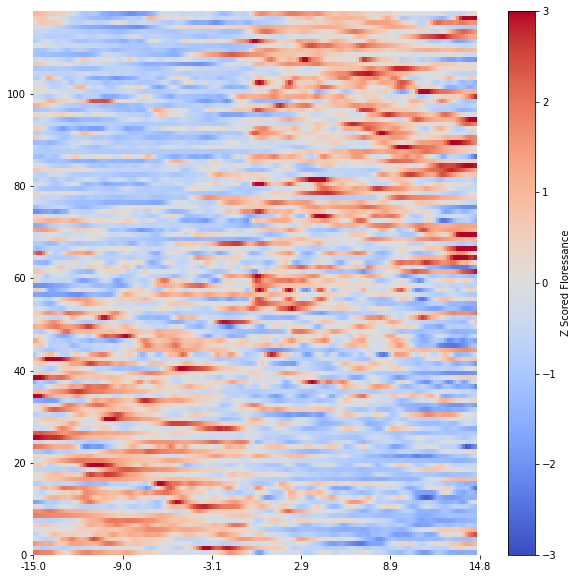

In [11]:
ax = plot_day4_heatmap("exp", -3, 3)

plt.savefig("Experimental_group_safe-to-danger.tiff")

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 264
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1a403203ac8>,
 <matplotlib.colorbar.Colorbar at 0x1a402993188>)

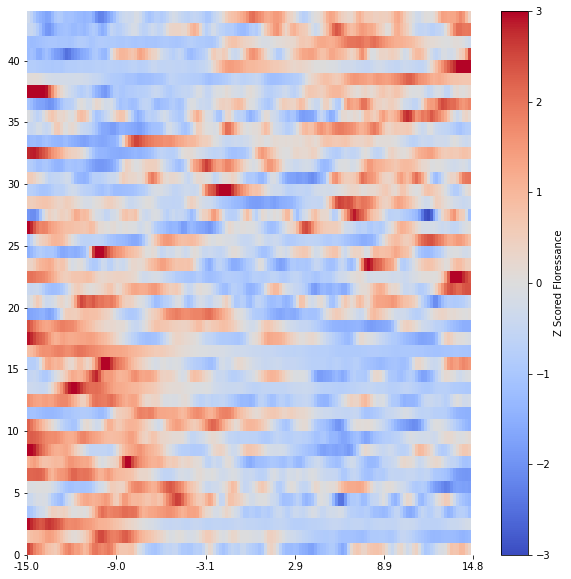

In [17]:
plot_day4_heatmap("one context", -3, 3)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 258
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1a402f01288>,
 <matplotlib.colorbar.Colorbar at 0x1a402f4f088>)

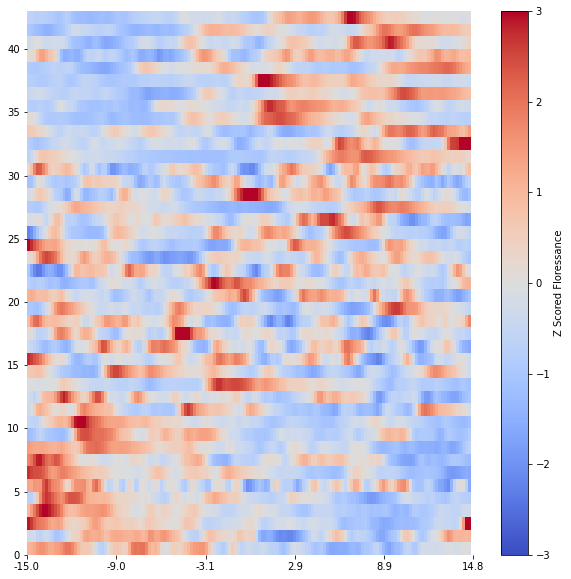

In [18]:
plot_day4_heatmap("no shock", -3, 3)

In [35]:
# align danger to safe

bins = np.array([120, 360])
df = (
    df_d4
    .pipe(lambda x: which_bin(
        x,
        bins,
        spiketimes_col="time",
        before=15,
        allow_before=False,
        max_latency=15
        ).rename(columns={"bin_idx": "trial_number"})
    )
    .drop("bin_values", axis=1)
    .pipe(align_around, events=bins, data_colname="time", t_before=15, max_latency=15)
    .dropna()
)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 472
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1a409d2c648>,
 <matplotlib.colorbar.Colorbar at 0x1a409ce24c8>)

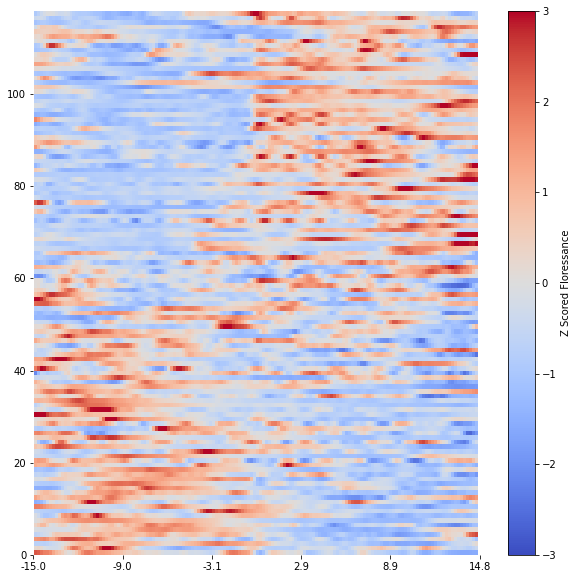

In [36]:
plot_day4_heatmap("exp", -3, 3)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 172
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1a40015a908>,
 <matplotlib.colorbar.Colorbar at 0x1a40bbf6908>)

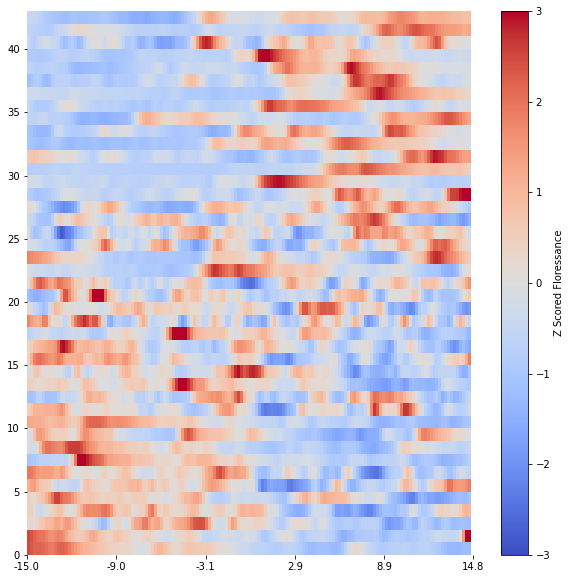

In [37]:
plot_day4_heatmap("no shock", -3, 3)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 176
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1a403e42688>,
 <matplotlib.colorbar.Colorbar at 0x1a402917ec8>)

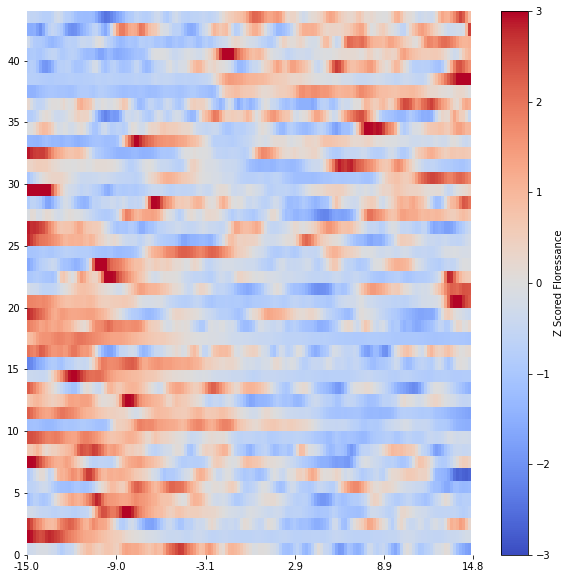

In [39]:
plot_day4_heatmap("one context", -3, 3)